In [ ]:
from skimage.color.colorconv import rgb2gray
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.filters as fil
import skimage.feature as feat
import skimage.exposure as exp
import skimage.morphology as mor
import skimage.measure as meas
from skimage.color import rgb2gray, gray2rgb
from skimage.morphology import disk, opening
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
def load_images():
  images_list = []
  for i in range(1):
    image = cv2.imread("03_h.jpg")
    images_list.append(image)
  return images_list

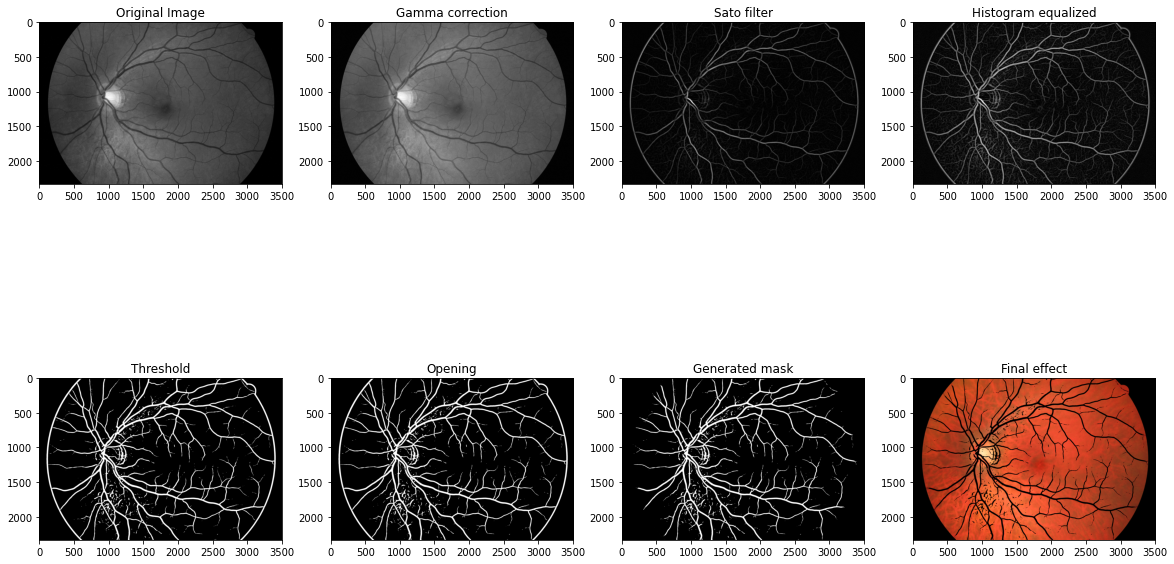

In [ ]:
images = load_images()

plt.figure(figsize=(20,12))

for image in images:
  img_red = image.copy()
  img_grn = image.copy()

  img_red[:,:,2] = 0
  img_red[:,:,1] = 0
  img_red = img_red / 255

  img_grn[:,:,0] = 0
  img_grn[:,:,2] = 0
  img_grn = img_grn / 255

  img_Q = img_red / (img_grn + 1)
  img_Q = rgb2gray(img_Q)
  img_Q = fil.median(img_Q)

  L_li = fil.threshold_li(img_Q)

  binary = img_Q >= L_li

  binary = fil.sato(binary, mode='constant')

  image = rgb2gray(img_grn)
  #1
  plt.subplot(241);
  plt.imshow(image, cmap="gray");
  plt.title("Original Image")
  #2
  plt.subplot(242);
  image = exp.adjust_gamma(image, 0.8)
  plt.imshow(image, cmap="gray");
  plt.title("Gamma correction")
  #3
  plt.subplot(243);
  image = fil.sato(image, mode='constant')
  plt.imshow(image, cmap="gray");
  plt.title("Sato filter")
  #4
  plt.subplot(244);
  image = exp.equalize_adapthist(image, clip_limit = 0.01);
  plt.imshow(image, cmap="gray");
  plt.title("Histogram equalized")
  #6
  plt.subplot(245)
  image = image > fil.threshold_otsu(image)
  plt.imshow(image, cmap="gray")
  plt.title("Threshold")
  #7
  plt.subplot(246)
  image = opening(image, disk(1))
  plt.imshow(image, cmap="gray");
  plt.title("Opening")
  #8
  plt.subplot(247)
  generated_mask = np.zeros(image.shape)
  generated_mask[np.where(image >= 0.6)] = 1
  generated_mask[np.where(binary > 0)] = 0
  plt.imshow(generated_mask, cmap="gray");
  plt.title("Generated mask")
  #8
  plt.subplot(248)
  orig_image = cv2.imread("02_h.jpg")
  orig_image[generated_mask == 1] = 0.2
  orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
  plt.imshow(orig_image)
  plt.title("Final effect")

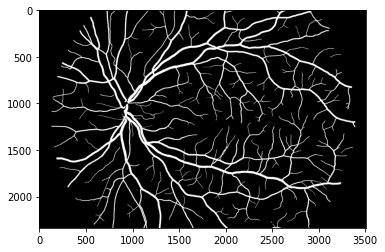

In [ ]:
org = cv2.imread('02_h.tif', 0)
org[org > 0] = 1
plt.imshow(org, cmap='gray');

In [ ]:
tp = np.sum(org[np.where(generated_mask == 1)] == 1)
fp = np.sum(org[np.where(generated_mask == 1)] == 0)
fn = np.sum(org[np.where(generated_mask == 0)] == 1)
tn = np.sum(org[np.where(generated_mask == 0)] == 0)
print('TP:', tp)
print('FP:', fp)
print('FN:', fn)
print('TN:', tn)

TP: 624142
FP: 146281
FN: 184296
TN: 7230625


In [ ]:
print(f'Sensivity: {round(tp / (tp + fn), 2) * 100}%')
print(f'Specificity: {round(tn / (tn + fp), 2) * 100}%')
print(f'Accuracy: {round((tn + tp) / (tp + fp + fn + tn), 2) * 100}%')
print(f'Geometric mean: {np.sqrt((tn / (tn + fp))*(tp / (tp + fn))):.2f}')

Sensivity: 77.0%
Specificity: 98.0%
Accuracy: 96.0%
Geometric mean: 0.87


# Klasyfikator KNN

In [ ]:
def divide_image(image):
    feat_list = list()
    for i in range(len(image)):
        l = 2
        r = 2
        if (i <= 2):
            l = i
        if (i >= len(image)-2):
            r = len(image) - i 
        for j in range(len(image[0])):
            u = 2 
            d = 2
            if (j <= 2):
                u = j
            if (j >= len(image[0])-2):
                d = len(image[0]) - j

            frag = image[i-l:i+r, j-u:j+d, :]
            color_var_r = np.var(frag[:,:,2])
            color_var_g = np.var(frag[:,:,1])
            color_var_b = np.var(frag[:,:,0])
            frag[:,:,0] = 0
            frag[:,:,2] = 0
            frag = rgb2gray(frag)
            hu_moments = cv2.HuMoments(cv2.moments(frag)).flatten()
            hu_moments = np.append(hu_moments, color_var_r)
            hu_moments = np.append(hu_moments, color_var_g)
            hu_moments = np.append(hu_moments, color_var_b)
            feat_list.append(hu_moments)
            del frag

    return feat_list

In [ ]:
X = cv2.imread('01_h.jpg')
feats = divide_image(X)
y = cv2.imread('01_h.tif', 0)
y[y > 0] = 1
y = y > 0

In [ ]:
y = y.flatten()

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(feats, y)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
feats = np.reshape(np.array(feats), (-1,1))

In [ ]:
test_img = cv2.imread('02_h.jpg')

test_img = test_img[:test_img.shape[0]//2, :test_img.shape[1]//2]
test_hu = divide_image(test_img)

In [ ]:
test_preds_2 = knn_model.predict(test_hu)

In [ ]:
fin_mask = cv2.imread('02_h.tif', 0)
fin_mask[fin_mask > 0] = 1
fin_mask = fin_mask[:test_img.shape[0], :test_img.shape[1]]
fin_mask = fin_mask > 0

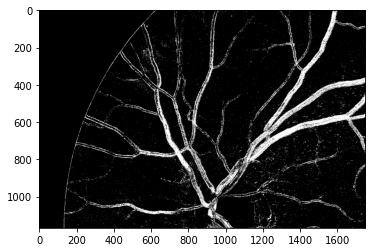

In [ ]:
plt.imshow(np.reshape(test_preds_2, fin_mask.shape), cmap='gray');

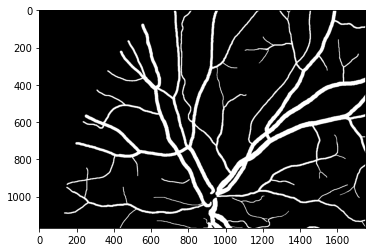

In [ ]:
plt.imshow(fin_mask, cmap='gray');

In [ ]:
mask_t = np.reshape(test_preds_2, fin_mask.shape)
tp = np.sum(fin_mask[np.where(mask_t == 1)] == 1)
fp = np.sum(fin_mask[np.where(mask_t == 1)] == 0)
fn = np.sum(fin_mask[np.where(mask_t == 0)] == 1)
tn = np.sum(fin_mask[np.where(mask_t == 0)] == 0)
print('TP:', tp)
print('FP:', fp)
print('FN:', fn)
print('TN:', tn)

TP: 109885
FP: 52193
FN: 114247
TN: 1770011


In [ ]:
print(f'Sensitivity: {round(tp / (tp + fn), 2) * 100}%')
print(f'Specificity: {round(tn / (tn + fp), 2) * 100}%')
print(f'Accuracy: {round((tn + tp) / (tp + fp + fn + tn), 2) * 100}%')
print(f'Geometric mean: {np.sqrt((tn / (tn + fp))*(tp / (tp + fn))):.2f}')

Sensivity: 49.0%
Specificity: 97.0%
Accuracy: 92.0%
Geometric mean: 0.69
